In [35]:
!pip install torch torchvision

In [134]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 
from scipy.io import loadmat
import numpy as np
import torch.utils.data
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from scipy import misc
import matplotlib.patches as patches
from datetime import datetime
from scipy.misc import imshow



feature_size = 136
output_size = 1
image_dim = 108
im_height = 60
im_width = 108

In [112]:
def image_eye_region(location, eye_region, show = True):
#     print(location)
    image = misc.imread(location.strip())
    (x,y,w,h) = eye_region
#     print(x,y,w,h, 'Now image shape', image.shape)
    
    eyes_image = image[y:y+h, x:x + w]

    if show is True:
        plt.imshow(image)
        rect = patches.Rectangle((x, y),w,h,linewidth=1,edgecolor='r',facecolor='none')
        ax = plt.gca()

        ax.add_patch(rect)
    
    print('Oblik je ', eyes_image.shape)
    return eyes_image

In [113]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, ftrs, locations, eye_regions, gz, train_transforms, test_transforms, load_type = 'train'): #NOVO POSLEDNJE
        self.ftrs = ftrs
        self.locations = locations
        self.eye_regions = eye_regions
        self.gz = gz
        self.load_type = load_type #NOVO

    def __len__(self):
        return self.eye_regions.shape[0]

    def __getitem__(self, idx):
    
        sample = image_eye_region(self.locations[idx], self.eye_regions[idx], False)   
        print(sample.shape)
        sample = torch.tensor(sample, dtype = torch.float)
        print(sample.shape)
        #SLIKA PROBA
        
        
        scaled_sample = image_transforms[self.load_type](sample).cuda() #NOVO
        scaled_sample = scaled_sample / 255.0
    
        ftrs_single = ftrs[idx]
    
        #SLIKA
        scaled_sample = scaled_sample.view(-1)
        print(scaled_sample.shape)
        x = torch.cat((ftrs_single, scaled_sample))
        return ( x , gz[idx])
    

In [153]:

class LandmarkUnit(nn.Module):
    def __init__(self, ):
        super(LandmarkUnit, self).__init__()

        self.fc1 = nn.Linear(feature_size, int(feature_size/2))  
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(int(feature_size/2), int(feature_size/2))

        self.fc3 = nn.Linear(int(feature_size/2), int(feature_size/4))

        self.fc5 = nn.Linear(int(feature_size/4), output_size)
#         self.fc5 = nn.Linear(int(feature_size/4), int(feature_size/4))


        self.out = nn.Sigmoid()


    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc5(x)
#         x = self.out(x)
        return x


image_unit_out = 1200
class ImageUnit(nn.Module):
    def __init__(self, ):
        super(ImageUnit, self).__init__()
     
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(3,5), stride=1, padding= (1, 2))
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=6, kernel_size=(3,5), stride=1, padding= (1, 2))
        self.relu2 = nn.ReLU()

        self.pool = nn.MaxPool2d(kernel_size=(2,4))

        self.conv3 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(3,5), stride=1, padding=(1, 2))
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3,5), stride=1, padding=(1, 2))
        self.relu4 = nn.ReLU()

#         self.fc = nn.Linear(in_features=image_dim/2 * image_dim/2 * 12, out_features=1)
    
#         self.fc = nn.Linear(in_features=image_dim/2 * image_dim/4 * 12, out_features=image_unit_out)
        self.fc = nn.Linear(in_features=image_dim/2 * image_dim/4/2 * 12, out_features=image_unit_out)

        self.relu5 = nn.ReLU()

        self.out = nn.Sigmoid()
        
        self.dropout02 = nn.Dropout(0.2)
        self.dropout05 = nn.Dropout(0.5)
        
    def forward(self,image):
        print('Slika-oblik', image.shape)
        output = self.conv1(image)
        print('Slika-oblik posle conv1', output.shape)
        output = self.relu1(output)

        output = self.conv2(output)
        print('Slika-oblik posle conv2', output.shape)

        output = self.relu2(output)

        output = self.pool(output)
        print('Slika-oblik posle pool', output.shape)

        output = self.conv3(output)
        print('Slika-oblik posle conv3', output.shape)

        output = self.relu3(output)

        output = self.conv4(output)
        output = self.relu4(output)
        print('Slika-oblik posle conv4', output.shape)


        
        print('simple', output.shape)
        output = output.view(-1, image_dim/2 * image_dim/4/2 * 12)
        print('simple', output.shape)
        output = self.dropout05(output)
        output = self.fc(output)
        print('simple', output.shape)

        return self.relu5(output)
#         return self.out(output)


class MultiModalNetwork(nn.Module):
    def __init__(self, ):
        super(MultiModalNetwork, self).__init__()
     
        
        #Load landmark model from file
        self.landmarkUnit = LandmarkUnit()
       
        self.landmarkUnit.load_state_dict(torch.load('best_136_model.py'))
        self.landmarkUnit.fc5 = nn.Linear(int(feature_size/4), int(feature_size/4))
        
        #Create new image unit needed to be trained
        self.imageUnit = ImageUnit()
        
        
        
        
        self.fc1 = nn.Linear(in_features=image_unit_out + int(feature_size/4), 
                             out_features=(image_unit_out + int(feature_size/4))/ 4)
    
        self.fc2 = nn.Linear(in_features=(image_unit_out + int(feature_size/4))/ 4,
                             out_features=(image_unit_out + int(feature_size/4))/ 16)

        self.fc3 = nn.Linear(in_features=(image_unit_out + int(feature_size/4))/ 16, out_features=1)

        self.dropout = nn.Dropout(0.5)
        
        self.out = nn.Sigmoid()
        
    
    def forward(self, x):
        landmarks = x[:, 0:136]
        #SLIKA
#         image = x[:, 136:].view(-1, 3, image_dim, image_dim/2)
        image = x[:, 136:].view(-1, image_dim/2, image_dim, 3) #NOVO
        image = image.permute(0,3,1,2) #NOVO

        
#         plt.imshow(image.permute(0,3,2,1).cpu().numpy()[0,:,:,:])
        
        print('Image ', image.shape)
        
        print('Landmarks ', landmarks.shape)

#         print(output.shape)
        imageUnitOut = self.forward_image(image)
    
        landmarksUnitOut = self.forward_landmarks(landmarks)
        
        
        print(imageUnitOut.shape, landmarksUnitOut.shape)
        output = torch.cat((imageUnitOut,landmarksUnitOut), dim = 1)
        
        
        output = self.dropout(output)
        output = self.fc1(output)
        
        output = self.dropout(output)
        output = self.fc2(output)
        
        output = self.dropout(output)
        output = self.fc3(output)
        
        output= self.out(output)
        
        
        return output
  
    
    def forward_image(self,image):        
        return self.imageUnit(image)

    def forward_landmarks(self, landmarks):
        return self.landmarkUnit(landmarks)


net = MultiModalNetwork().cuda()

for param in net.landmarkUnit.parameters():
    param.requires_grad = False

#only unfreeze last layer of landmark unit
net.landmarkUnit.fc5.requires_grad = True

net.landmarkUnit.eval()
net.landmarkUnit.fc5.train()

optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
print(net)

MultiModalNetwork(
  (landmarkUnit): LandmarkUnit(
    (fc1): Linear(in_features=136, out_features=68, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=68, out_features=68, bias=True)
    (fc3): Linear(in_features=68, out_features=34, bias=True)
    (fc5): Linear(in_features=34, out_features=34, bias=True)
    (out): Sigmoid()
  )
  (imageUnit): ImageUnit(
    (conv1): Conv2d(3, 6, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2))
    (relu1): ReLU()
    (conv2): Conv2d(6, 6, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2))
    (relu2): ReLU()
    (pool): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(6, 12, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2))
    (relu3): ReLU()
    (conv4): Conv2d(12, 12, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2))
    (relu4): ReLU()
    (fc): Linear(in_features=8748, out_features=1200, bias=True)
    (relu5): ReLU()
    (out): Sigmoid()
    (dropout02): Dropout(p=0.2)
    

In [154]:
def extract_data(indices, suffix = '', include_pos = True):
  ftrs = torch.Tensor()
  ftrs = ftrs.type(torch.cuda.FloatTensor)  
  gz = torch.Tensor()
  gz = gz.type(torch.cuda.FloatTensor) 
    
  eye_reg = torch.Tensor()
  eye_reg = eye_reg.type(torch.cuda.IntTensor)
    
    
  img_loc = np.asarray([])
#   img_loc = img_loc.type(torch.cuda.FloatTensor) 
  
  for index in indices:
    data = loadmat(str(index) + suffix + '_lmarks_location_eye.mat')
    
    #Landmark features
    ftrs_single = torch.from_numpy(data['ftrs'])
    
    
    ftrs_single = ftrs_single.type(torch.cuda.FloatTensor)  

    
    ftrs = torch.cat((ftrs, ftrs_single))
    
    #Gaze features

    gz_single = torch.from_numpy(data['gz'])
    gz_single = gz_single.type(torch.cuda.FloatTensor)  

    gz_single = torch.t(gz_single)

    gz = torch.cat((gz, gz_single))
    
    
    #Eye regions should be n X 4 size
    
    eye_reg_single = torch.from_numpy(data['eye_reg'])
    eye_reg_single = eye_reg_single.type(torch.cuda.IntTensor)
    
    
    eye_reg = torch.cat((eye_reg, eye_reg_single))
    
    
    #Get image location
    
    img_loc_single = data['location']
        
    img_loc = np.concatenate((img_loc, img_loc_single))
    
  return(ftrs, gz, eye_reg, img_loc)


In [155]:

def train_model(net, face_landmarks_dataset, epochs_count = 10, view_step = 10, include_graph = True, batch_size = 32768, 
                output_file = 'multimodal_log.txt'):
    f = open(output_file, 'w') 
    
    net.train()
    errors_array = []
    f.write('Batch size is %d' % (batch_size))
    f.write('\n')

    for epochs in range(epochs_count):
#       dataset = torch.utils.data.TensorDataset(x,y)
#       trainloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
      trainloader = torch.utils.data.DataLoader(dataset=face_landmarks_dataset , batch_size=batch_size, shuffle=True)
      f.write('Batch size is %d' % (batch_size))
      f.write('Next batch')
      f.write('\n')


      then = datetime.now()

      for i, (train_batch) in enumerate(trainloader):
            
          #calculating time
          now  = datetime.now()  
          duration = now - then 
        
          seconds = duration.total_seconds()
          minutes = divmod(seconds, 60)[0]
            
            
          f.write(str(datetime.now().time()))
          f.write('Time for training passed %d minutes and %d seconds' % (minutes, seconds))
          #for measuring starting time
          then = datetime.now()
            
            
          (x_batch, y_batch) = train_batch
          optimizer.zero_grad()
          yhat = torch.Tensor()
        
          yhat = yhat.type(torch.cuda.FloatTensor)  
            
            
          yhat = net(x_batch) 

          loss = nn.BCELoss()
            
#           print('tip', type(yhat), 'tip2', type(y_batch), 'tip3 ' , type(x_batch))
#           print(yhat.shape, y_batch.shape)
          output_loss = loss(yhat, y_batch)

          output_loss.backward()
          optimizer.step()
            


          yhat = yhat > 0.5
          accuracy = accuracy_score(yhat.cpu().data.numpy(), y_batch.cpu().numpy())
            
            

          f.write('This batch accuracy is %f %%' % (100.0 * accuracy))
            
        
          f.write('Completed %d/%d  %f %%, epoch: %d' % (batch_size*i, len(face_landmarks_dataset) , 
                                            100.0 * batch_size*i / len(face_landmarks_dataset), epochs))
            

      if(epochs % view_step == 0):
        f.write('Epoch %d loss is %f accuracy is: %f' % (epochs, output_loss.item(), accuracy))
      
      errors_array.append(output_loss.item())

    if(include_graph):
      plt.xlabel('Epochs')
      plt.ylabel('Errors')
      plt.plot(errors_array, label='Error')
    
    f.write(net)
    return net
  


In [156]:
def test_model(net, test_face_landmarks_dataset, batch_size = 128):
  net.eval()
#   y_total = torch.Tensor().cuda()
#   y_hat_total = torch.Tensor().cuda()

  accuracies = []

  testloader = torch.utils.data.DataLoader(dataset=test_face_landmarks_dataset , batch_size=batch_size, shuffle=True)
  
  then = datetime.now()

  for i, (train_batch) in enumerate(testloader):

      #calculating time
      now  = datetime.now()  
      duration = now - then 

      seconds = duration.total_seconds()
      minutes = divmod(seconds, 60)[0]


      print(datetime.now().time())
      print('Time for testing passed %d minutes and %d seconds' % (minutes, seconds))
      #for measuring starting time
      then = datetime.now()


      (x_batch, y_batch) = train_batch
      optimizer.zero_grad()
      yhat = torch.Tensor()
      yhat = yhat.type(torch.cuda.FloatTensor)  


      yhat = net(x_batch) 


      yhat = yhat > 0.5
      accuracy = accuracy_score(yhat.cpu().numpy(), y_batch.cpu().numpy())



      print('This batch accuracy is %f %%' % (100.0 * accuracy) )
      print('Completed %d/%d  %f %%' % (batch_size*(i + 1), len(test_face_landmarks_dataset) , 100.0 * batch_size*(i + 1) / len(test_face_landmarks_dataset)))

      yhat = ftrs.type(torch.cuda.FloatTensor)  

    
      accuracies.append(accuracy)
  

  return (accuracies)

  

In [118]:
!ls 

401_lmarks_location_eye.mat		Figure_6.png
401_lmarks.mat				Figure_7.png
402_lmarks_location_eye.mat		Figure_8.png
402_lmarks.mat				Find face landmark positions.ipynb
403_lmarks_location_eye.mat		hyperparameter_tuning_results.txt
403_lmarks.mat				landmark_eye_region_backup
404_demo_lmarks.mat			list_mine.txt
404_demo_output_results.npy		multimodal_final.ipynb
404_lmarks_location_eye.mat		multimodal_log_1.txt
404_lmarks.mat				multimodal_log_2.txt
405_lmarks_location_eye.mat		multimodal_log_3.txt
405_lmarks.mat				multimodal_log_4.txt
407_lmarks_location_eye.mat		multimodal_log_5.txt
407_lmarks.mat				multimodal_log_6_32.txt
410_lmarks_location_eye.mat		multimodal_log.txt
410_lmarks.mat				multimodal_model_1.py
best_136_model.py			multimodal_model_6_32.py
check.png				multi_modal_model.py
detect_landmarks_in_image.py		multimodal_nn.ipynb
detect_landmarks_in_image_v2.py		multimodal.py
detect_landmarks_in_image_v3.py		out1.txt
detect_landmarks_in_image_v4.py		out2.txt
detect_landmarks_i

In [158]:
train_indices = [401,402,403,405]
# test_indices = [404, 407,410]
test_indices = [404,407,410]




ftrs = torch.Tensor()
gz = torch.Tensor()

(ftrs, gz, eye_reg, img_loc) = extract_data(train_indices)



print(gz.shape)
print(ftrs.shape)
print(eye_reg.shape)
print(img_loc.shape)

torch.Size([390029, 1])
torch.Size([390029, 136])
torch.Size([390029, 4])
(390029,)


### Finding mean,median and distribution (histogram)  of eye region sizes

Mean for x and y are (107.051254, 65.154716)
Median for x and y are (108.000000, 60.000000)


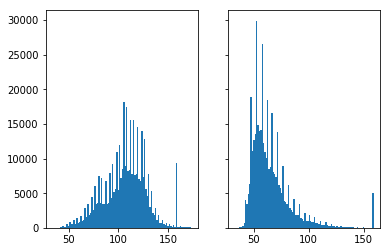

In [159]:
eye_reg = eye_reg.type(torch.cuda.FloatTensor) 

print('Mean for x and y are (%f, %f)' %(torch.mean(eye_reg[:, 2]), torch.mean(eye_reg[:, 3])))
print('Median for x and y are (%f, %f)' %(torch.median(eye_reg[:, 2]), torch.median(eye_reg[:, 3])))

hist_x = torch.histc(eye_reg[:, 2])
hist_y = torch.histc(eye_reg[:, 3])

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True)
ax1.hist(eye_reg[:,2].cpu().numpy(), bins=100)
ax2.hist(eye_reg[:,3].cpu().numpy(), bins=100)
fig.show()


eye_reg = eye_reg.type(torch.cuda.IntTensor) 

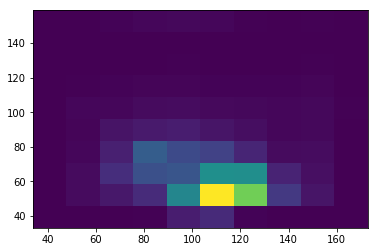

In [160]:
eye_reg = eye_reg.type(torch.cuda.FloatTensor) 

fig, ax = plt.subplots()

ax.hist2d(eye_reg[:,2].cpu().numpy(), eye_reg[:,3].cpu().numpy())
eye_reg = eye_reg.type(torch.cuda.IntTensor) 

### Around 88 by 45 is a good measure to start, we will use 88 x 88 for future resizing  for imagenet classifiers

In [161]:
image_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_dim/2, image_dim)),
        
        transforms.RandomRotation(90),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
#         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_dim/2, image_dim)),
        transforms.ToTensor(),
#         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

In [162]:
# eyes_image = image_eye_region(img_loc[index], eye_reg[index], show = False)

def make_image_batch(locations, eye_regions, batch_size):
    image_array = torch.zeros(batch_size, image_dim, image_dim, 3)

    for i in range(batch_size):
        eyes_image = torch.from_numpy(image_eye_region(locations[index], eye_regions[index], show = False))
        scaled_eyes_image = image_transforms['train'](eyes_image)
        scaled_eyes_image = scaled_eyes_image.permute(1,2,0)
        image_array[i,:,:,:] = scaled_eyes_image


    return image_array


('Oblik je ', (59, 118, 3))


/home/flash/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


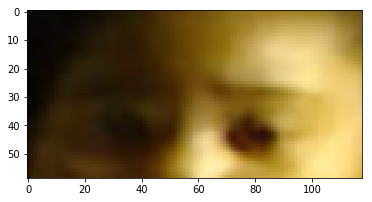

In [163]:
index = 100000
eyes_image = image_eye_region(img_loc[index], eye_reg[index], show = False)


plt.imshow(eyes_image)

('Oblik je ', (59, 118, 3))
torch.Size([54, 108, 3])


/home/flash/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


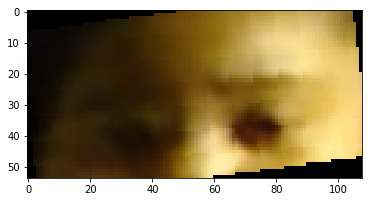

In [164]:
eyes_image = image_eye_region(img_loc[index], eye_reg[index], show = False)
new = image_transforms['train'](eyes_image)



#Switching dimensions to work
new = new.permute(1,2,0)
print(new.shape)
plt.imshow(new)

torch.Size([1, 54, 108, 3])
torch.Size([17496])
('E', (1,))
('E', (17496, 324, 3, 1))
torch.Size([1, 54, 108, 3])


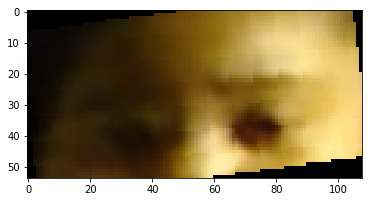

In [165]:
really_new = new[None, :, :, :]
# print(really_new.shape, really_new.stride())
print(really_new.shape)

really_new = really_new.contiguous()
viewed_image = really_new.view(-1)
print(viewed_image.shape)
print('E',viewed_image.stride())
image = viewed_image.view(-1, image_dim/2, image_dim, 3)
print('E',image.stride())
print(image.shape)
plt.imshow(image[0,:,:,:].cpu().numpy())

In [166]:
#Take out test data

test_ftrs = torch.Tensor().cuda()
test_gz = torch.Tensor().cuda()

(test_ftrs, test_gz, test_eye_reg, test_img_loc) = extract_data(test_indices)

print(test_gz.shape)
print(test_ftrs.shape)


torch.Size([263857, 1])
torch.Size([263857, 136])


In [167]:
print(torch.cuda.memory_allocated())

device = torch.device("cuda:0")
torch.cuda.current_device()

634789888


0L

In [129]:
img_loc.shape

(390029,)

In [130]:
face_landmarks_dataset[100000][0][None, :]

('Oblik je ', (59, 118, 3))
(59, 118, 3)
torch.Size([59, 118, 3])
torch.Size([17496])


/home/flash/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


tensor([[19., 65., 15.,  ...,  0.,  0.,  0.]], device='cuda:0')

In [168]:
face_landmarks_dataset = FaceLandmarksDataset(ftrs = ftrs, eye_regions= eye_reg.cuda(), locations=img_loc,  gz = gz.cuda(), train_transforms=None, test_transforms=None)


print(torch.cuda.memory_allocated())

y = gz.cuda()




# x.requires_grad = False
y.requires_grad = False

# x = train_input
# y = train_output

print(torch.cuda.memory_allocated())

# print(x.requires_grad, y.requires_grad)
# def train_model(net, face_landmarks_dataset, epochs_count = 10, view_step = 10, include_graph = True, batch_size):
net = train_model(net, face_landmarks_dataset , 2, 1, True, batch_size = 32, output_file = 'multimodal_log.txt')

416373248
414640128
('Oblik je ', (84, 146, 3))
(84, 146, 3)
torch.Size([84, 146, 3])
torch.Size([17496])
('Oblik je ', (58, 121, 3))
(58, 121, 3)
torch.Size([58, 121, 3])
torch.Size([17496])
('Oblik je ', (55, 118, 3))
(55, 118, 3)
torch.Size([55, 118, 3])
torch.Size([17496])
('Oblik je ', (75, 116, 3))
(75, 116, 3)
torch.Size([75, 116, 3])
torch.Size([17496])
('Oblik je ', (49, 117, 3))
(49, 117, 3)
torch.Size([49, 117, 3])
torch.Size([17496])
('Oblik je ', (62, 129, 3))
(62, 129, 3)
torch.Size([62, 129, 3])
torch.Size([17496])
('Oblik je ', (54, 128, 3))
(54, 128, 3)
torch.Size([54, 128, 3])
torch.Size([17496])
('Oblik je ', (109, 119, 3))
(109, 119, 3)
torch.Size([109, 119, 3])
torch.Size([17496])
('Oblik je ', (63, 120, 3))
(63, 120, 3)
torch.Size([63, 120, 3])
torch.Size([17496])
('Oblik je ', (51, 139, 3))
(51, 139, 3)
torch.Size([51, 139, 3])
torch.Size([17496])


/home/flash/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


('Oblik je ', (75, 86, 3))
(75, 86, 3)
torch.Size([75, 86, 3])
torch.Size([17496])
('Oblik je ', (47, 110, 3))
(47, 110, 3)
torch.Size([47, 110, 3])
torch.Size([17496])
('Oblik je ', (71, 95, 3))
(71, 95, 3)
torch.Size([71, 95, 3])
torch.Size([17496])
('Oblik je ', (109, 105, 3))
(109, 105, 3)
torch.Size([109, 105, 3])
torch.Size([17496])
('Oblik je ', (50, 100, 3))
(50, 100, 3)
torch.Size([50, 100, 3])
torch.Size([17496])
('Oblik je ', (48, 103, 3))
(48, 103, 3)
torch.Size([48, 103, 3])
torch.Size([17496])
('Oblik je ', (56, 135, 3))
(56, 135, 3)
torch.Size([56, 135, 3])
torch.Size([17496])
('Oblik je ', (77, 80, 3))
(77, 80, 3)
torch.Size([77, 80, 3])
torch.Size([17496])
('Oblik je ', (50, 108, 3))
(50, 108, 3)
torch.Size([50, 108, 3])
torch.Size([17496])
('Oblik je ', (90, 73, 3))
(90, 73, 3)
torch.Size([90, 73, 3])
torch.Size([17496])
('Oblik je ', (52, 89, 3))
(52, 89, 3)
torch.Size([52, 89, 3])
torch.Size([17496])
('Oblik je ', (50, 98, 3))
(50, 98, 3)
torch.Size([50, 98, 3])
tor

KeyboardInterrupt: 

In [51]:
x_test = test_ftrs
y_test = test_gz

test_face_landmarks_dataset = FaceLandmarksDataset(ftrs = test_ftrs, eye_regions=test_eye_reg.cuda(), locations=test_img_loc,  gz = test_gz.cuda(), train_transforms=None, test_transforms=None, 'test')


# (error, accuracy) = test_model(net, test_ftrs, test_gz)
(accuracy) = test_model(net, test_face_landmarks_dataset)


print('Total accuracies:' )
print(accuracies)

/home/flash/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


17:12:42.623979
Time for testing passed 0 minutes and 2 seconds
('Image ', torch.Size([128, 3, 44, 44]))
('Landmarks ', torch.Size([128, 136]))
This batch accuracy is 71.093750 %
Completed 128/263857  0.048511 %
17:12:44.928730
Time for testing passed 0 minutes and 2 seconds
('Image ', torch.Size([128, 3, 44, 44]))
('Landmarks ', torch.Size([128, 136]))
This batch accuracy is 72.656250 %
Completed 256/263857  0.097022 %
17:12:47.919838
Time for testing passed 0 minutes and 2 seconds
('Image ', torch.Size([128, 3, 44, 44]))
('Landmarks ', torch.Size([128, 136]))
This batch accuracy is 74.218750 %
Completed 384/263857  0.145533 %
17:12:50.248268
Time for testing passed 0 minutes and 2 seconds
('Image ', torch.Size([128, 3, 44, 44]))
('Landmarks ', torch.Size([128, 136]))
This batch accuracy is 75.000000 %
Completed 512/263857  0.194045 %
17:12:52.575175
Time for testing passed 0 minutes and 2 seconds
('Image ', torch.Size([128, 3, 44, 44]))
('Landmarks ', torch.Size([128, 136]))
This bat

RuntimeError: CUDA out of memory. Tried to allocate 1.78 GiB (GPU 0; 10.91 GiB total capacity; 3.31 GiB already allocated; 1.67 GiB free; 2.08 GiB cached)

In [ ]:
torch.save(net.state_dict(), 'new_multi_modal_model.py')


In [50]:
net = MultiModalNetwork().cuda()

for param in net.landmarkUnit.parameters():
    param.requires_grad = False
net.load_state_dict(torch.load('multi_modal_model.py'))
# model.eval()

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## **Check all hyperparameters**
---



In [ ]:
lr_array = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
epoch_count_array = [25, 50, 75, 100, 125]
momentum_array = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
batch_size_array = [2048, 4096, 8192, 16384, 32768]

x = ftrs.cuda()
y = gz.cuda()

x_test = test_ftrs
y_test = test_gz


x.requires_grad = False
y.requires_grad = False

f=open("hyperparameter_tuning_results.txt", "w+")



for lr in lr_array:
    for epoch_count in epoch_count_array:
        for momentum in momentum_array:
            for batch_size in batch_size_array:
                  print('Doing for lr=%f,epoch_count=%d,momentum=%f,batch_size=%d' % (lr, epoch_count,momentum,batch_size))
                  f.write('Doing for lr=%f,epoch_count=%d,momentum=%f,batch_size=%d' % (lr, epoch_count,momentum,batch_size))
                  optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum = momentum)
                  net = NeuralNetwork().cuda()
                    
                  net = train_model(net, x, y, epoch_count, 1, False, batch_size)
                  (error, accuracy) = test_model(net, test_ftrs, test_gz)
                    
                  print('Error is: %f and accuracy is: %f' % (error, accuracy))
                  
                  f.write('Error is: %f and accuracy is: %f' % (error, accuracy))


f.close()